In [1]:
# does everybody really die in the summer?

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# read in the data

shots = pd.read_csv('data/boston_shots_fired.csv')
shots.head()

,incident_num,incident_date,district,ballistics_evidence
0,I152000093-00,2015-01-01 04:17:00+00,C11,f
1,I152000042-00,2015-01-01 00:05:00+00,A15,f
2,I152000514-00,2015-01-02 15:51:00+00,B3,t
3,I152000965-00,2015-01-04 15:30:00+00,B2,t
4,I152000872-00,2015-01-04 00:13:00+00,B2,f


In [3]:
# cleaning up shots data

# we don't particuarly need the incident number as it stands
shots = shots.drop(columns=['incident_num'])

# let's convert the date column to a datetime object
shots['incident_date'] = pd.to_datetime(shots['incident_date'])

# let's simplify the incident_date column to show just year, month, and day
shots['incident_date'] = shots['incident_date'].dt.date
shots['incident_date'] = pd.to_datetime(shots['incident_date'])

# let's convert the ballistic_evidence entry to a boolean
shots['ballistics_evidence'] = shots['ballistics_evidence'] == 't'

In [4]:
# read in weather data
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

# combine weather data
weather = pd.concat([weather1, weather2, weather3])

# isolate the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather.head()

,DATE,AWND,PRCP,SNOW,TAVG
0,2015-01-01,14.32,0.00,0.0,26
1,2015-01-02,12.75,0.00,0.0,34
2,2015-01-03,10.29,0.62,1.4,28
3,2015-01-04,8.28,0.57,0.0,38
4,2015-01-05,22.15,0.00,0.0,40


In [5]:
shots.head()

,incident_date,district,ballistics_evidence
0,2015-01-01,C11,False
1,2015-01-01,A15,False
2,2015-01-02,B3,True
3,2015-01-04,B2,True
4,2015-01-04,B2,False


In [6]:
weather.head()

,DATE,AWND,PRCP,SNOW,TAVG
0,2015-01-01,14.32,0.00,0.0,26
1,2015-01-02,12.75,0.00,0.0,34
2,2015-01-03,10.29,0.62,1.4,28
3,2015-01-04,8.28,0.57,0.0,38
4,2015-01-05,22.15,0.00,0.0,40


In [7]:
# let's add the weather data to the shots data
shots_daily = pd.merge(shots, weather, left_on='incident_date', right_on='DATE')

# dropping redundant date column and wind speed (might reintroduce this later, though)
shots_daily = shots_daily.drop(columns=['DATE', 'AWND'])

# converting ballistics_evidence to a boolean
shots_daily['ballistics_evidence'] = shots_daily['ballistics_evidence'] == 1

shots_daily.head()

,incident_date,district,ballistics_evidence,PRCP,SNOW,TAVG
0,2015-01-01,C11,False,0.00,0.0,26
1,2015-01-01,A15,False,0.00,0.0,26
2,2015-01-02,B3,True,0.00,0.0,34
3,2015-01-02,E13,False,0.00,0.0,34
4,2015-01-04,B2,True,0.57,0.0,38


In [8]:
shots_daily['district'] = shots_daily['district'].astype('category')

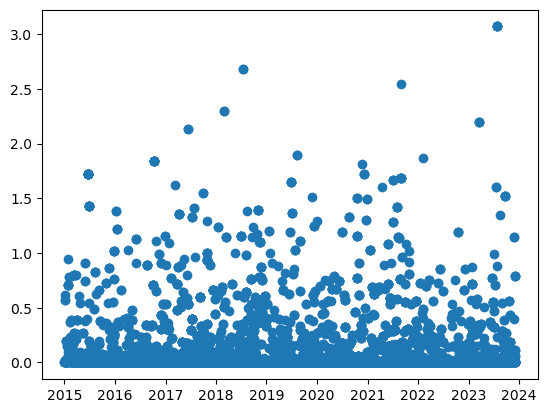

In [9]:
# let's plot the number of shots fired per day as a scatter plot, where each entry represents a shot fired

plt.scatter(shots_daily['incident_date'], shots_daily['PRCP'])

In [10]:
# as much as i'd like to take credit for the math in the function below, i cant
# thanks to jake vanderplas for the code!

import datetime
def hours_of_daylight(date, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - datetime.datetime(date.year, 1, 1)
    day_of_year = diff.days + float(diff.seconds) / (24 * 60 * 60)
    days_in_year = 365.2425  # average number of days in a year, accounting for leap years
    axial_tilt = 23.44  # axial tilt of the Earth

    # Calculate the declination angle
    declination = axial_tilt * np.sin(np.radians(360.0 * (day_of_year + 10) / days_in_year))

    # Calculate the hour angle
    hour_angle = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))

    # Calculate the daylight hours
    daylight_hours = 2 * np.degrees(hour_angle) / 15

    return daylight_hours

# let's add the hours of daylight to the dataframe
shots_daily['hours_of_daylight'] = shots_daily['incident_date'].apply(hours_of_daylight)


In [11]:
shots_daily.head()

,incident_date,district,ballistics_evidence,PRCP,SNOW,TAVG,hours_of_daylight
0,2015-01-01,C11,False,0.00,0.0,26,12.587640
1,2015-01-01,A15,False,0.00,0.0,26,12.587640
2,2015-01-02,B3,True,0.00,0.0,34,12.646087
3,2015-01-02,E13,False,0.00,0.0,34,12.646087
4,2015-01-04,B2,True,0.57,0.0,38,12.762693


Text(0, 0.5, 'hours of daylight')

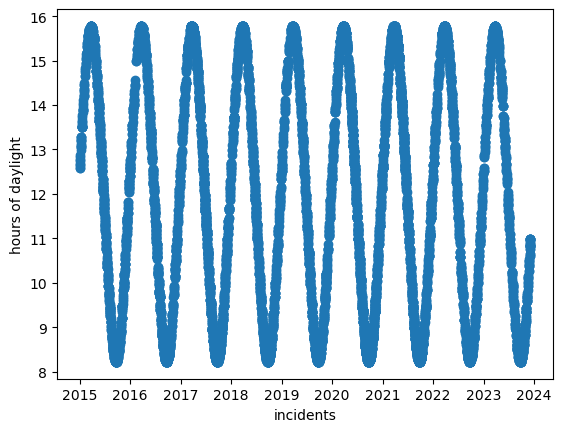

In [15]:
plt.scatter(shots_daily['incident_date'], shots_daily['hours_of_daylight'])
plt.xlabel('incidents')
plt.ylabel('hours of daylight')

# very interesting. on first glance, the hours of daylight doesn't seem to
# have much of a correlation with the incident count
# this sort of makes sense, as you may imagine that illegal activity might occur
# more often at night, when there is less daylight

Text(0, 0.5, 'incident count')

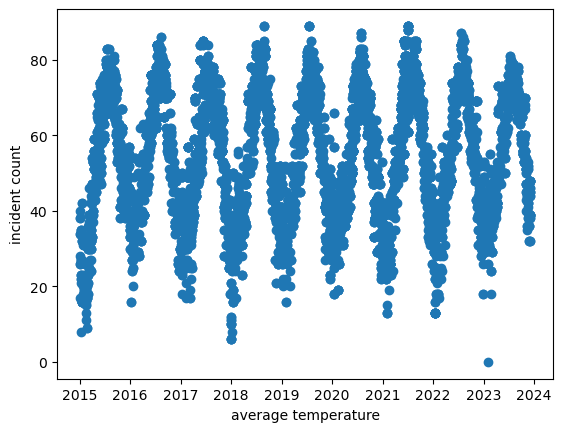

In [17]:
plt.scatter(shots_daily['incident_date'], shots_daily['TAVG'])
plt.xlabel('average temperature')
plt.ylabel('average temp')

# the average temperature seems to have a stronger correlation with the incident count

Text(0, 0.5, 'incident count')

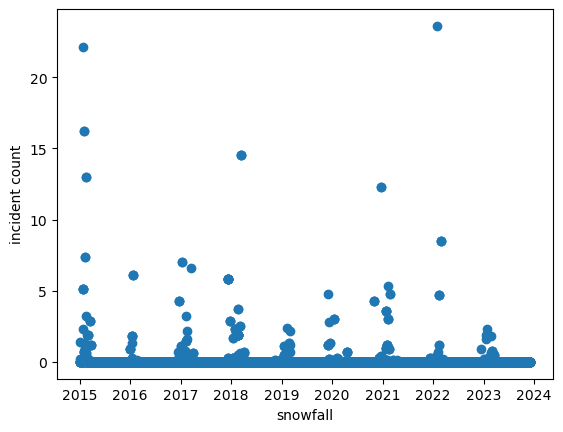

In [18]:
plt.scatter(shots_daily['incident_date'], shots_daily['SNOW'])
plt.xlabel('incidents')
plt.ylabel('snowfall')

# on first glance, it looks like the snowfall has a stronger correlation
# but since snowfall is relatively rare, it's hard to say for sure

Text(0, 0.5, 'incidents')

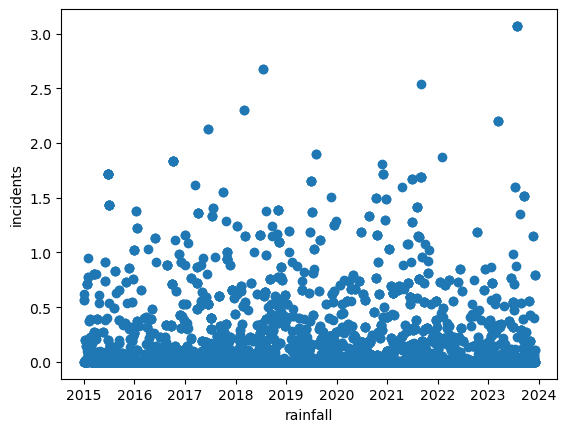

In [19]:
plt.scatter(shots_daily['incident_date'], shots_daily['PRCP'])
plt.xlabel('rainfall')
plt.ylabel('incidents')

In [ ]:
shots_daily.head()

,incident_date,district,ballistics_evidence,incident_count,PRCP,SNOW,TAVG,hours_of_daylight
0,2015-01-01,C11A15,False,2,0.00,0.0,26,12.587640
1,2015-01-02,B3E13,True,2,0.00,0.0,34,12.646087
2,2015-01-03,B2,False,1,0.62,1.4,28,12.704440
3,2015-01-04,B2B2,True,2,0.57,0.0,38,12.762693
4,2015-01-05,C6,False,1,0.00,0.0,40,12.820834
